Deep Learning
=============

Assignment 3
------------

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [20]:
import logging
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt 

from six.moves import range
from six.moves import cPickle as pickle

tf.get_logger().setLevel(logging.ERROR)


def reformat(dataset, labels, n_labels=10):
    dataset = dataset.reshape((-1, dataset.shape[1] * dataset.shape[-1])).astype(np.float32)
    labels = (np.arange(n_labels) == labels[:, None]).astype(np.float32)
    
    return dataset, labels


def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1)) / predictions.shape[0])


In [21]:
pickle_file = 'data/notMNIST.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_labels = save['train_labels']
    valid_dataset = save['valid_dataset']
    valid_labels = save['valid_labels']
    test_dataset = save['test_dataset']
    test_labels = save['test_labels']
    del save  
    
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)

print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


---
Problem 1
---------

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---

Test accuracy: 89.5%


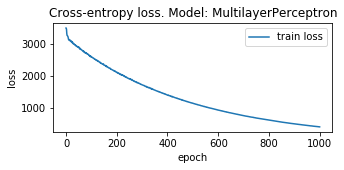

Test accuracy: 84.5%


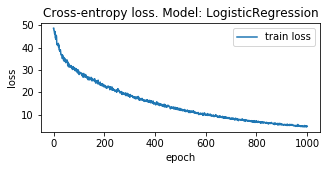

In [66]:
tf.compat.v1.set_random_seed(42)  

class MultilayerPerceptron(object):
    
    def __init__(self, n_hidden: int = 1024, n_input: int = 784, n_labels: int = 10):

        super().__init__()

    def __call__(self, x):
        layer_1 = tf.compat.v1.matmul(x, weights['h1']) + biases['b1']
        activation = tf.nn.relu(layer_1)
        
        return tf.compat.v1.matmul(activation, weights['out']) + biases['out']
        

class LogisticRegression(object):
    
    def __init__(self, n_input: int = 784, n_labels: int = 10):

        super().__init__()

    def __call__(self, x):                      
        return tf.compat.v1.matmul(x, weights['lm']) + biases['out']
    

# define training parameters   
n_labels = 10
train_subset = 10000

lr = 0.1
n_input = 784
n_hidden = 1024
batch_size = 128
num_steps = 1001
display_step = 100

for est_class in [MultilayerPerceptron, LogisticRegression]:
    est = est_class()
    graph = tf.Graph()
    with graph.as_default():
        # load datasets
        tf_train_dataset = tf.compat.v1.placeholder(tf.float32, shape=(batch_size, n_input))
        tf_train_labels = tf.compat.v1.placeholder(tf.float32, shape=(batch_size, n_labels))
        tf_valid_dataset = tf.constant(valid_dataset)
        tf_test_dataset = tf.constant(test_dataset)

        # initialize weights and biases
        weights = {
            'h1': tf.Variable(tf.compat.v1.truncated_normal([n_input, n_hidden])),
            'out': tf.Variable(tf.compat.v1.truncated_normal([n_hidden, n_labels])),
            'lm': tf.Variable(tf.compat.v1.truncated_normal([n_input, n_labels]))
        }
        biases = {'b1': tf.Variable(tf.zeros([n_hidden])), 'out': tf.Variable(tf.zeros([n_labels]))}

        # train the model
        logits = est(tf_train_dataset)
        # loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))

        if isinstance(est, MultilayerPerceptron):
            c = 0.01
            l2_regularization = np.sum([c * tf.nn.l2_loss(weights['h1']), c * tf.nn.l2_loss(biases['b1']),
                                   c * tf.nn.l2_loss(weights['out']), c * tf.nn.l2_loss(biases['out'])])
        else: 
            #c = 1e-1
            l2_regularization = np.sum([c * tf.nn.l2_loss(weights['lm']), c * tf.nn.l2_loss(biases['out'])])       
        
        loss = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits) + l2_regularization)

        optimizer = tf.compat.v1.train.GradientDescentOptimizer(lr).minimize(loss)

        # get predictions
        train_prediction = tf.nn.softmax(logits)
        valid_prediction = tf.nn.softmax(est(tf_valid_dataset))
        test_prediction = tf.nn.softmax(est(tf_test_dataset))

    # model training
    loss_logs = list()
    with tf.compat.v1.Session(graph=graph) as session:
        tf.compat.v1.global_variables_initializer().run()
        for epoch in range(num_steps):
            offset = (epoch * batch_size) % (train_labels.shape[0] - batch_size)
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]

            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
            _, l, predictions = session.run(
                [optimizer, loss, train_prediction], feed_dict=feed_dict)
            loss_logs.append(l)
        print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

    plt.figure(figsize=(5,2))
    plt.plot(loss_logs, label='train loss')
    plt.title(f'Cross-entropy loss. Model: {est.__class__.__name__}')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.show()
                                   
    del est

---
Problem 2
---------
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

---

---
Problem 3
---------
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

---

---
Problem 4
---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
 ---
